In [1]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.callbacks import CSVLogger

Using TensorFlow backend.


In [2]:
# load the pretrained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# extend the model, it has 3 outputs to the 3 labels
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(8, activation='relu')(x)
pred = Dense(3, activation='softmax')(x)

model = Model(base_model.input, pred)

In [4]:
# at first the InceptionV3 layers must not learn
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# with load_data.ipynb these folders will contain the images
# (400-400-400 in the train folder, 100-100-100 in the valid and test folder)
base_dir = 'dataset'
train_dir = base_dir+'/train'
train_0_dir = train_dir + '/0'
train_1_dir = train_dir + '/1'
train_2_dir = train_dir + '/2'
valid_dir = base_dir+'/valid'
valid_0_dir = valid_dir + '/0'
valid_1_dir = valid_dir + '/1'
valid_2_dir = valid_dir + '/2'
test_dir = base_dir+'/test'
test_0_dir = test_dir + '/0'
test_1_dir = test_dir + '/1'
test_2_dir = test_dir + '/2'

In [6]:
# data generators to read and preprocess big amount of data
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen  = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function = preprocess_input)
# the input size of the InceptionV3 is (299,299), and we will use 32 as batch size
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299,299),batch_size=32)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(299,299),batch_size=32)
test_generator = valid_datagen.flow_from_directory(test_dir, target_size=(299,299),batch_size=32)

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [7]:
# plot 5 of the original images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgs = []
for i in range(5):
    src = ("dataset/test/0/%s.jpg" % i)
    img = mpimg.imread(src)[:,:,0:3]
    imgs.append(img)
fig, axs = plt.subplots(1, 5, figsize = (30,30))
for i in range(5):
    axs[i].imshow(imgs[i])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


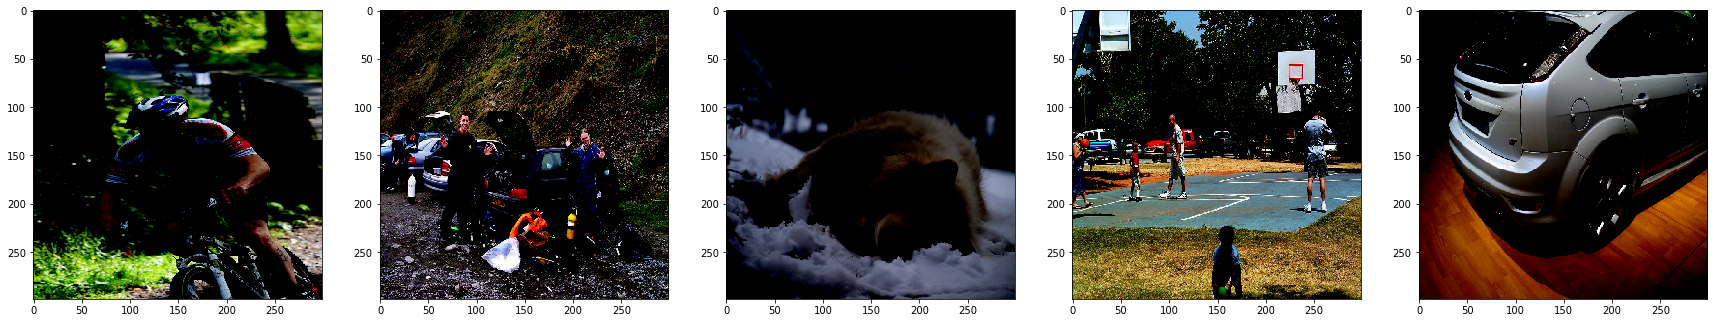

In [8]:
# plot 5 preprocessed images to see if the preprocessing was successful
imgs = []
for i in range(5):
    img=test_generator[0][0][i]
    imgs.append(img)
fig, axs = plt.subplots(1, 5, figsize = (30,30))
for i in range(5):
    axs[i].imshow(imgs[i])

In [9]:
# compile the model with cathegorical_crossentropy loss function and adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# create logger callbacks to log the train results
csv1_logger = CSVLogger('log1.csv', append=True, separator=';')
csv2_logger = CSVLogger('log2.csv', append=True, separator=';')

In [11]:
# train the model
# for example the validation_steps is: int(300/32)+1
    # because we have 300 validation images, 32 batch_size 
    # and the +1 because int(300/32)=floor(300/32)
model.fit_generator(train_generator, 
                    validation_data=valid_generator, validation_steps=int(300/32)+1, 
                    epochs=8, steps_per_epoch=int(1200/32)+1,
                    callbacks=[csv1_logger])

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
38/38 [==============================] - 101s 3s/step - loss: 0.8963 - acc: 0.5155 - val_loss: 0.5177 - val_acc: 0.9433
Epoch 2/8
38/38 [==============================] - 70s 2s/step - loss: 0.4778 - acc: 0.9169 - val_loss: 0.5477 - val_acc: 0.8000
Epoch 3/8
38/38 [==============================] - 70s 2s/step - loss: 0.4208 - acc: 0.9490 - val_loss: 0.4379 - val_acc: 0.9533
Epoch 4/8
38/38 [==============================] - 70s 2s/step - loss: 0.4173 - acc: 0.9416 - val_loss: 0.5040 - val_acc: 0.9067
Epoch 5/8
38/38 [==============================] - 70s 2s/step - loss: 0.4176 - acc: 0.9350 - val_loss: 0.3726 - val_acc: 0.9200
Epoch 6/8
38/38 [==============================] - 70s 2s/step - loss: 0.3981 - acc: 0.9572 - val_loss: 0.3581 - val_acc: 0.9267
Epoch 7/8
38/38 [==============================] - 70s 2s/step - loss: 0.3841 - acc: 0.9449 - val_loss: 0.3424 - val_acc: 0.9800
Epoch 8/8
38/38 [==============================]

In [12]:
# the size of the base model layers
print(len(base_model.layers))

311


In [13]:
# let the top 20 layer learn
for layer in base_model.layers[-20:]:
    layer.trainable=True

In [14]:
# re-compile the model, because we changed the trainable property of some layers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# train again
model.fit_generator(train_generator, 
                    validation_data=valid_generator, validation_steps=int(300/32)+1, 
                    epochs=8, steps_per_epoch=int(1200/32)+1,
                    callbacks=[csv2_logger])

Epoch 1/8
38/38 [==============================] - 81s 2s/step - loss: 0.4181 - acc: 0.9235 - val_loss: 0.3475 - val_acc: 0.9633
Epoch 2/8
38/38 [==============================] - 73s 2s/step - loss: 0.3293 - acc: 0.9605 - val_loss: 0.2820 - val_acc: 0.9767
Epoch 3/8
38/38 [==============================] - 73s 2s/step - loss: 0.3057 - acc: 0.9589 - val_loss: 0.2772 - val_acc: 0.9767
Epoch 4/8
38/38 [==============================] - 73s 2s/step - loss: 0.2810 - acc: 0.9704 - val_loss: 0.2657 - val_acc: 0.9867
Epoch 5/8
38/38 [==============================] - 73s 2s/step - loss: 0.2642 - acc: 0.9770 - val_loss: 0.2594 - val_acc: 0.9867
Epoch 6/8
38/38 [==============================] - 73s 2s/step - loss: 0.2377 - acc: 0.9852 - val_loss: 0.2734 - val_acc: 0.9733
Epoch 7/8
38/38 [==============================] - 73s 2s/step - loss: 0.2283 - acc: 0.9811 - val_loss: 0.2272 - val_acc: 0.9800
Epoch 8/8
38/38 [==============================] - 73s 2s/step - loss: 0.2068 - acc: 0.9893 - val

In [16]:
# evaluate the model on the test data
test_loss, test_acc = model.evaluate_generator(test_generator,steps = int(300/32)+1, verbose = 1)

10/10 [==============================] - 15s 2s/step


In [17]:
# show the results
print("Test loss:",test_loss)
print("Test accuracy:",test_acc)

Test loss: 0.22543559730052948
Test accuracy: 0.9666666666666667
